In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [96]:
import cairo
num_imgs = 1000

img_size = 16
min_object_size = 2
max_object_size = 8
num_objects = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA
shapes = np.zeros((num_imgs, num_objects), dtype=int)
num_shapes = 3
shape_labels = ['rectangle', 'circle', 'triangle']
colors = np.zeros((num_imgs, num_objects), dtype=int)
num_colors = 3
color_labels = ['r', 'g', 'b']

for i_img in range(num_imgs):
    surface = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_ARGB32, img_size, img_size)
    cr = cairo.Context(surface)

    # Fill background white.
    cr.set_source_rgb(1, 1, 1)
    cr.paint()
    
    # TODO: Try no overlap here.
    # Draw random shapes.
    for i_object in range(num_objects):
        shape = np.random.randint(num_shapes)
        shapes[i_img, i_object] = shape
        if shape == 0:  # rectangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            bboxes[i_img, i_object] = [x, y, w, h]
            cr.rectangle(x, y, w, h)            
        elif shape == 1:  # circle   
            r = 0.5 * np.random.randint(min_object_size, max_object_size)
            x = np.random.randint(r, img_size - r)
            y = np.random.randint(r, img_size - r)
            bboxes[i_img, i_object] = [x - r, y - r, 2 * r, 2 * r]
            cr.arc(x, y, r, 0, 2*np.pi)
        elif shape == 2:  # triangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            bboxes[i_img, i_object] = [x, y, w, h]
            cr.move_to(x, y)
            cr.line_to(x+w, y)
            cr.line_to(x+w, y+h)
            cr.line_to(x, y)
            cr.close_path()
        
        # Put some variation to the colors by adding a small random offset to the rgb values.
        color = np.random.randint(num_colors)
        colors[i_img, i_object] = color
        max_offset = 0.3
        r_offset, g_offset, b_offset = max_offset * 2. * (np.random.rand(3) - 0.5)
        if color == 0:
            cr.set_source_rgb(1-max_offset+r_offset, 0+g_offset, 0+b_offset)
        elif color == 1:
            cr.set_source_rgb(0+r_offset, 1-max_offset+g_offset, 0+b_offset)
        elif color == 2:
            cr.set_source_rgb(0+r_offset, 0-max_offset+g_offset, 1+b_offset)
        cr.fill()
        
imgs = imgs[..., 2::-1]  # is BGRA, convert to RGB

imgs.shape, bboxes.shape, shapes.shape, colors.shape

((1000, 16, 16, 3), (1000, 3, 4), (1000, 3), (1000, 3))

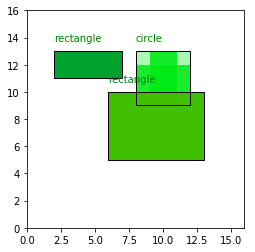

In [97]:
i = 2
plt.imshow(imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape, color in zip(bboxes[i], shapes[i], colors[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='k', fc='none'))
    plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), color=color_labels[color], clip_on=False)

In [98]:
imgs = np.transpose(imgs,(0,3,1,2))
print imgs.shape

(1000, 3, 16, 16)


In [99]:
X = (imgs - 128.) / 255.
X.shape, np.mean(X), np.std(X)

((1000, 3, 16, 16), 0.37750297691993473, 0.29189804501498112)

In [100]:
colors_onehot = np.zeros((num_imgs, num_objects, num_colors))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        colors_onehot[i_img, i_object, colors[i_img, i_object]] = 1

shapes_onehot = np.zeros((num_imgs, num_objects, num_shapes))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        shapes_onehot[i_img, i_object, shapes[i_img, i_object]] = 1
        
y = np.concatenate([bboxes / img_size, shapes_onehot, colors_onehot], axis=-1).reshape(num_imgs, -1)
y.shape, np.all(np.argmax(colors_onehot, axis=-1) == colors)

((1000, 30), True)

In [101]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]
print train_X.shape,train_y.shape

(800, 3, 16, 16) (800, 30)


In [102]:
from torchsummary import summary
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [103]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()

        #conv 1
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu1=nn.ReLU()

        #Maxpool 1
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        #conv 2
        self.cnn2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.relu2=nn.ReLU()

        #Maxpool 2
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        #conv 3
        self.cnn3=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2)
        self.relu3=nn.ReLU()

        #Maxpool 3
        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        
        #FC 1
        self.fc1=nn.Linear(1152,256)
        self.relu4=nn.ReLU()
            
        #Drop out 
        self.dropout1 = nn.Dropout(0.2)
        
        #FC 2
        self.fc2=nn.Linear(256,30)
        

    def forward(self,x):
        '''
        ori=x[0][0].data.numpy()
        print ('original : ',ori.shape)
        plt.imshow(ori, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        #conv1
        out=self.cnn1(x)
        out=self.relu1(out)
        '''
        #print type(out)
        intm=out[0][0].data.numpy()
        print ('conv 1: ',intm.shape)
        #imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        
        #max poo1 1
        out=self.maxpool1(out)
        '''
        ap=out[0][0].data.numpy()
        print ('maxpool 1 : ',ap.shape)
        plt.imshow(ap, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        
        
        #conv2
        out=self.cnn2(out)
        out=self.relu2(out)
        '''
        intm=out[0][0].data.numpy()
        print ('conv 2: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        
        #max poo1 2
        out=self.maxpool2(out)
        '''
        ap=out[0][0].data.numpy()
        print ('maxpool 2 : ',ap.shape)
        plt.imshow(ap, cmap=plt.get_cmap('gray'))
        plt.show()
        '''
        
        #conv3
        out=self.cnn3(out)
        out=self.relu3(out)
        '''
        intm=out[0][0].data.numpy()
        print ('conv 3: ',intm.shape)
        imgplot = plt.imshow(intm)
        plt.imshow(intm, cmap=plt.get_cmap('gray'))
        plt.show(),
        '''
        
        #max poo1 3
        out=self.maxpool3(out)
        """ap=out[0][0].data.numpy()
        print ('maxpool 3 : ',ap.shape)
        plt.imshow(ap, cmap=plt.get_cmap('gray'))
        plt.show()
        """
        
        out=out.view(out.size(0),-1)        
        #fc1
        out=self.fc1(out)
        out=self.relu4(out) 
        
        
        #dropout
        out=self.dropout1(out)
        
        #fc2
        out=self.fc2(out)
        
        return out

In [104]:
model = CNNModel()

print summary(model, (3, 16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 32L, 18L, 18L]             896
              ReLU-2        [-1, 32L, 18L, 18L]               0
         MaxPool2d-3          [-1, 32L, 9L, 9L]               0
            Conv2d-4        [-1, 64L, 11L, 11L]           18496
              ReLU-5        [-1, 64L, 11L, 11L]               0
         MaxPool2d-6          [-1, 64L, 5L, 5L]               0
            Conv2d-7         [-1, 128L, 7L, 7L]           73856
              ReLU-8         [-1, 128L, 7L, 7L]               0
         MaxPool2d-9         [-1, 128L, 3L, 3L]               0
           Linear-10                 [-1, 256L]          295168
             ReLU-11                 [-1, 256L]               0
          Dropout-12                 [-1, 256L]               0
           Linear-13                  [-1, 30L]            7710
Total params: 396126
Trainable params: 

In [105]:
model=CNNModel()
criterion=nn.MSELoss()
learning_rate=0.01
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [106]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def dist(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))


In [107]:
num_epochs_flipping = 100

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(train_y), num_epochs_flipping ))
ious_epoch = np.zeros((len(train_y), num_epochs_flipping ))
dists_epoch = np.zeros((len(train_y), num_epochs_flipping ))
mses_epoch = np.zeros((len(train_y), num_epochs_flipping ))
acc_shapes_epoch = np.zeros((len(train_y), num_epochs_flipping ))
acc_colors_epoch = np.zeros((len(train_y), num_epochs_flipping ))
#print flipped,ious_epoch,flipped.shape,ious_epoch.shape

In [108]:
loss_list=[]
for epoch in range(num_epochs_flipping):
    #print 'Epoch', epoch
    inputs=Variable(torch.FloatTensor(train_X))
    #print 'input size {}'.format(inputs.shape)
    labels=Variable(torch.FloatTensor(flipped_train_y))
    optimizer.zero_grad()
    outputs = model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    #if epoch%100==0:
    print ('epoch {}, loss {}'.format(epoch,loss.data[0])) 
    loss_list.append(loss.data[0])

    pred_y = model(Variable(torch.FloatTensor(train_X))).data.numpy()
    #print 'pred {}'.format(pred_y)
    for sample, (pred, exp) in enumerate(zip(pred_y, flipped_train_y)):
        
        # TODO: Make this simpler.
        
        pred = pred.reshape(num_objects, -1)
        exp = exp.reshape(num_objects, -1)
        #print 'Pred {}'.format(pred.shape)
        #print 'exp {}'.format(exp.shape)
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        #print 'sizes of ious dists mses {}'.format(ious.shape)
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = dist(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
        #print ious
                
        new_order = np.zeros(num_objects, dtype=int)
        
        #print 'new_order {} '.format(new_order.shape)
        for i in range(num_objects):
            # Find pred and exp bbox with maximum iou and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            #print 'ious.argmax() {}'.format(ious.argmax())
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(ious.argmax(), ious.shape)
            #print 'ind_exp_bbox {}, ind_pred_bbox {}'.format(ind_exp_bbox, ind_pred_bbox)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            #print 'ious_epoch {}'.format(ious_epoch)
            ious[ind_exp_bbox] = -1  # set iou of assigned bboxes to -1, so they don't get assigned again
            ious[:, ind_pred_bbox] = -1
            #print 'ious_epoch {}'.format(ious_epoch)
            new_order[ind_pred_bbox] = ind_exp_bbox
            #print 'new_order {} '.format(new_order)
        
        flipped_train_y[sample] = exp[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
        acc_shapes_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4:4+num_shapes], axis=-1) == np.argmax(exp[:, 4:4+num_shapes], axis=-1))
        acc_colors_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1) == np.argmax(exp[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1))
        #print 'Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.)
    print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
    print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
    print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))
    print 'Accuracy shapes: {}'.format(np.mean(acc_shapes_epoch[:, epoch]))
    print 'Accuracy colors: {}'.format(np.mean(acc_colors_epoch[:, epoch]))
    print '----------------------------------------------------------------'

epoch 0, loss 0.243518233299
Mean IOU: 0.0
Mean dist: 10.2385147444
Mean mse: 48.2319692879
Accuracy shapes: 0.33875
Accuracy colors: 0.3325
----------------------------------------------------------------
epoch 1, loss 48.1049575806
Mean IOU: 0.00271587529485
Mean dist: 0.433211106271
Mean mse: 0.0891320936352
Accuracy shapes: 0.345833333333
Accuracy colors: 0.331666666667
----------------------------------------------------------------
epoch 2, loss 0.214309871197
Mean IOU: 0.0
Mean dist: 0.520148350472
Mean mse: 0.125893356001
Accuracy shapes: 0.320833333333
Accuracy colors: 0.335833333333
----------------------------------------------------------------
epoch 3, loss 0.250291883945
Mean IOU: 0.0
Mean dist: 0.525583667173
Mean mse: 0.128562310383
Accuracy shapes: 0.327916666667
Accuracy colors: 0.335833333333
----------------------------------------------------------------
epoch 4, loss 0.253443270922
Mean IOU: 0.0
Mean dist: 0.525359451079
Mean mse: 0.128635441969
Accuracy shapes: 0

epoch 36, loss 0.150190189481
Mean IOU: 0.140198574647
Mean dist: 0.276904196246
Mean mse: 0.03163590149
Accuracy shapes: 0.328333333333
Accuracy colors: 0.348333333333
----------------------------------------------------------------
epoch 37, loss 0.149491488934
Mean IOU: 0.135782391211
Mean dist: 0.276307946901
Mean mse: 0.0319212725971
Accuracy shapes: 0.344166666667
Accuracy colors: 0.341666666667
----------------------------------------------------------------
epoch 38, loss 0.148268818855
Mean IOU: 0.139723241607
Mean dist: 0.272340940573
Mean mse: 0.0307430154904
Accuracy shapes: 0.338333333333
Accuracy colors: 0.35375
----------------------------------------------------------------
epoch 39, loss 0.148283794522
Mean IOU: 0.137163038245
Mean dist: 0.270436670718
Mean mse: 0.0299974031593
Accuracy shapes: 0.339583333333
Accuracy colors: 0.33875
----------------------------------------------------------------
epoch 40, loss 0.147818669677
Mean IOU: 0.133115877483
Mean dist: 0.2700

epoch 72, loss 0.147246822715
Mean IOU: 0.14900103235
Mean dist: 0.264306536533
Mean mse: 0.0295666618577
Accuracy shapes: 0.338333333333
Accuracy colors: 0.352916666667
----------------------------------------------------------------
epoch 73, loss 0.147046878934
Mean IOU: 0.144359381134
Mean dist: 0.265903457042
Mean mse: 0.029920403282
Accuracy shapes: 0.337916666667
Accuracy colors: 0.350833333333
----------------------------------------------------------------
epoch 74, loss 0.146823659539
Mean IOU: 0.142046365631
Mean dist: 0.265965135004
Mean mse: 0.0301631691552
Accuracy shapes: 0.346666666667
Accuracy colors: 0.360416666667
----------------------------------------------------------------
epoch 75, loss 0.147230789065
Mean IOU: 0.142833072298
Mean dist: 0.264205296347
Mean mse: 0.02970280001
Accuracy shapes: 0.335
Accuracy colors: 0.354583333333
----------------------------------------------------------------
epoch 76, loss 0.146893754601
Mean IOU: 0.14309091518
Mean dist: 0.26

In [109]:
pred_y1  = model(Variable(torch.FloatTensor(test_X))).data.numpy()
pred_y1 = pred_y1.reshape(len(pred_y1), num_objects, -1)
pred_bboxes = pred_y1[..., :4] * img_size
pred_shapes = np.argmax(pred_y1[..., 4:4+num_shapes], axis=-1).astype(int)  # take max from probabilities
# print pred_y[..., 4+num_shapes:4+num_shapes+num_colors].shape
# print np.argmax(pred_y[..., 5:8], axis=-1).shape
pred_colors = np.argmax(pred_y1[..., 4+num_shapes:4+num_shapes+num_colors], axis=-1).astype(int)
pred_bboxes.shape, pred_shapes.shape, pred_colors.shape

((200, 3, 4), (200, 3), (200, 3))

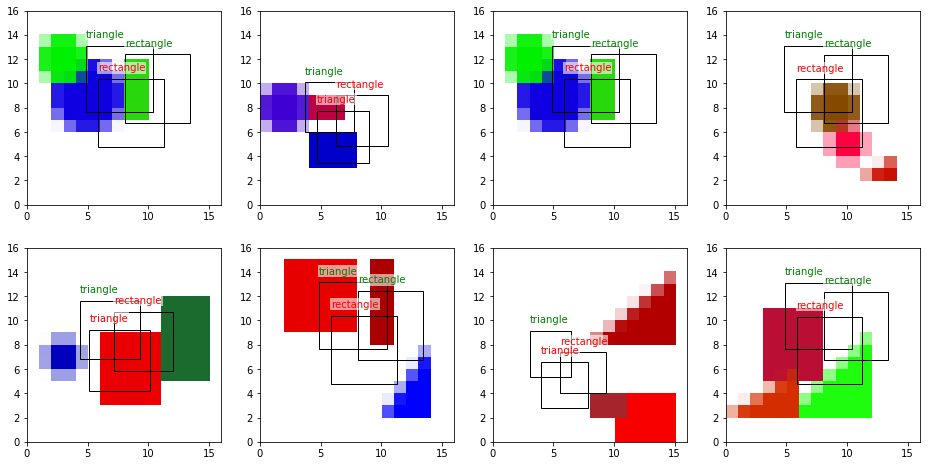

In [110]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    #print test_imgs[i].transpose(1,2,0).shape
    plt.imshow(test_imgs[i].transpose(1,2,0), interpolation='none', origin='lower', extent=[0, 16, 0, 16])
    for bbox, shape, color in zip(pred_bboxes[i], pred_shapes[i], pred_colors[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='k', fc='none'))
        plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), color=color_labels[color], clip_on=False, bbox={'fc': 'w', 'ec': 'none', 'pad': 1, 'alpha': 0.6})


In [29]:
torch.save(model.state_dict(), 'multibox_notflipped_chk.pt')

## The bounding boxes are centered to the objects in the data
## We need to handle the case of flipping 
reference https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491